In [1]:
#import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns

In [2]:
dateparser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dataset = pd.read_csv('C:/Faculta anul 3 sem 2/Licenta/DJIA/DIS.csv', sep=',', index_col = 'Date', parse_dates = ['Date'], date_parser = dateparser).fillna(0)
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,111.809998,108.559998,108.949997,111.800003,11014300.0,108.726067
2018-01-03,113.190002,111.449997,112.190002,112.279999,9237900.0,109.192856
2018-01-04,113.000000,111.629997,112.949997,112.230003,7417400.0,109.144241
2018-01-05,112.680000,111.239998,112.680000,111.620003,6008300.0,108.551003
2018-01-08,111.279999,109.540001,110.889999,110.019997,8052600.0,106.994995


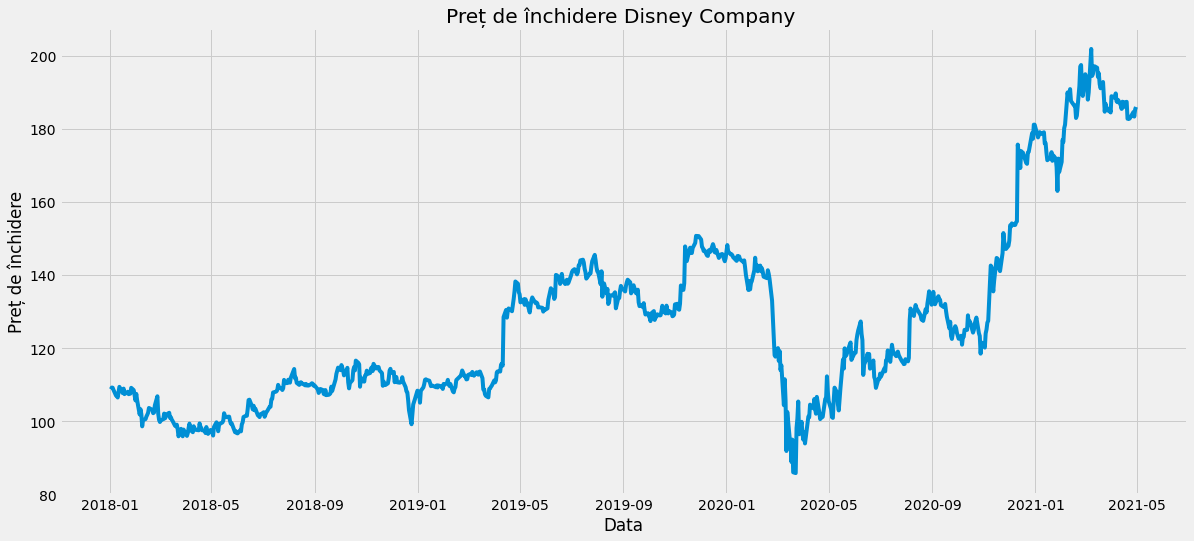

In [3]:
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(dataset['Adj Close'])
plt.title('Preț de închidere Disney Company ')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

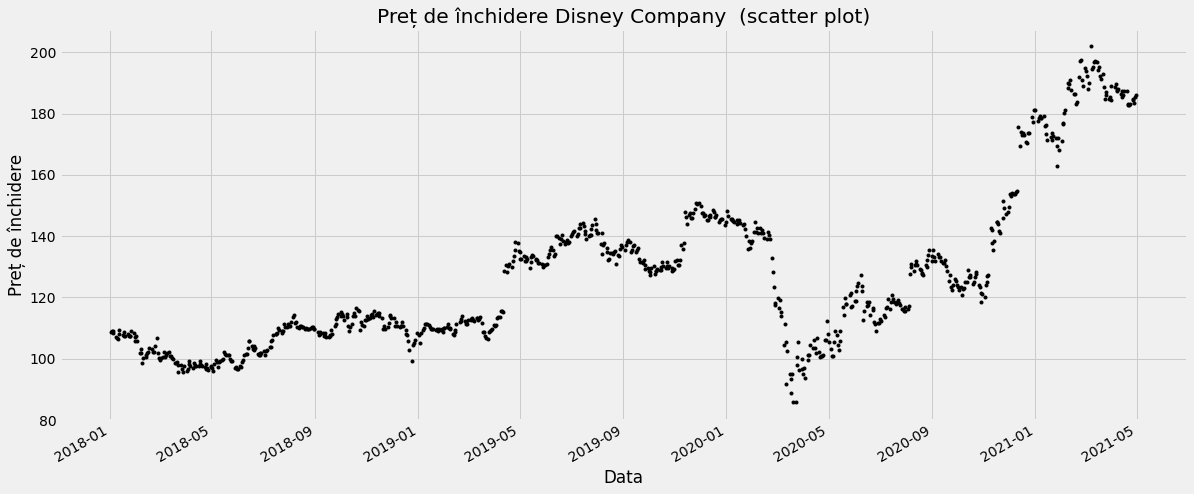

In [4]:
df_close = dataset['Adj Close']
df_close.plot(style='k.')
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.title('Preț de închidere Disney Company  (scatter plot)')
plt.show

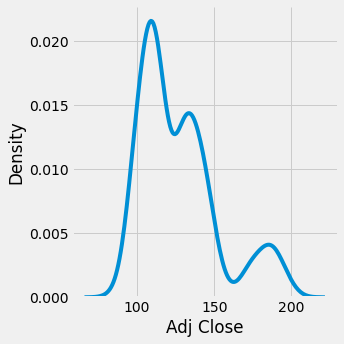

In [5]:
density = sns.displot(dataset, x="Adj Close", kind="kde")

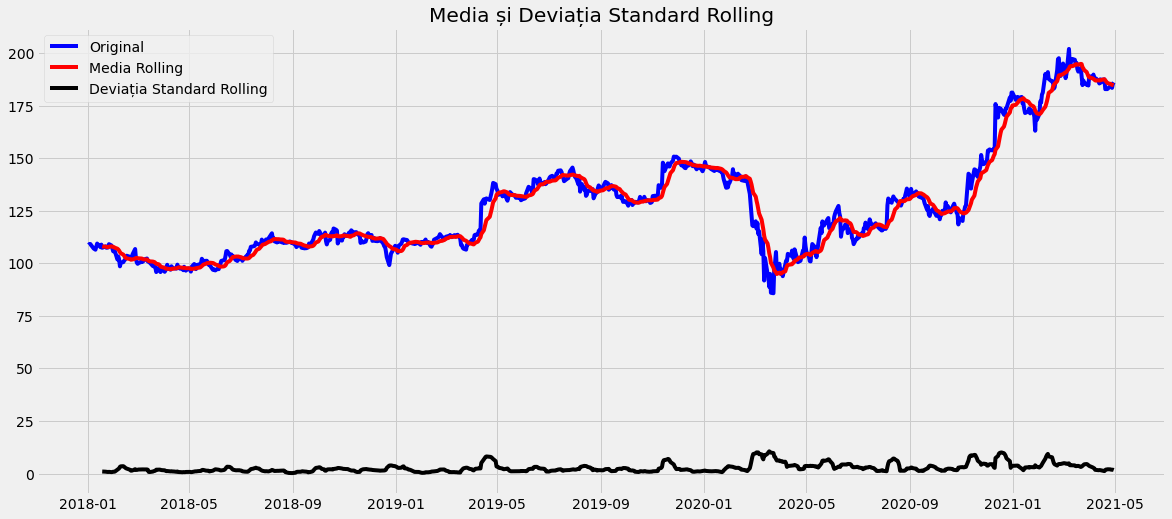

Rezultatele testului Dickey-Fuller Augmentat: 
Test statistic            -0.659864
p-value                    0.856874
Nr. decalaje folosite     10.000000
Nr. observatii           827.000000
valoare critica (1%)      -3.438282
valoare critica (5%)      -2.865041
valoare critica (10%)     -2.568634
dtype: float64


In [6]:
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(12).mean()
    rolling_std = timeseries.rolling(12).std()
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label='Media Rolling')
    plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
    plt.legend(loc='best')
    plt.title('Media și Deviația Standard Rolling')
    plt.show(block=False)
    
    print('Rezultatele testului Dickey-Fuller Augmentat: ')
    adft = adfuller(timeseries, autolag = 'AIC')
    results = pd.Series(adft[0:4],index=['Test statistic','p-value','Nr. decalaje folosite','Nr. observatii'])
    for key, value in adft[4].items():
        results['valoare critica (%s)' %key] = value
    print(results)
test_stationarity(df_close)

<Figure size 1296x576 with 0 Axes>

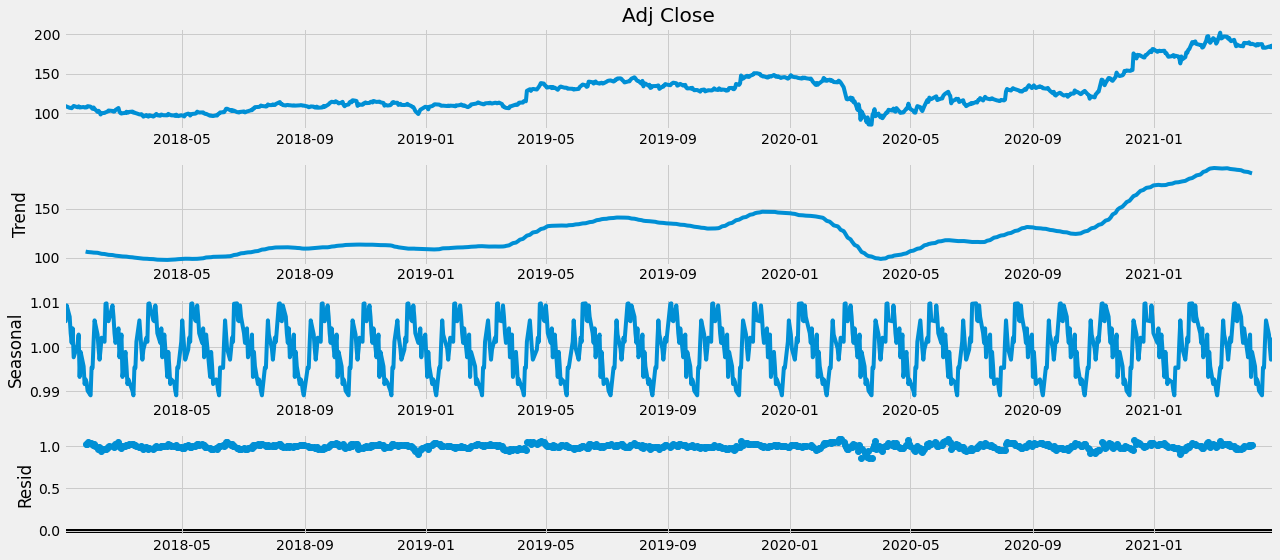

In [7]:
result = seasonal_decompose(df_close, model='multiplicative',freq = 30)
fig = plt.figure()
fig = result.plot()

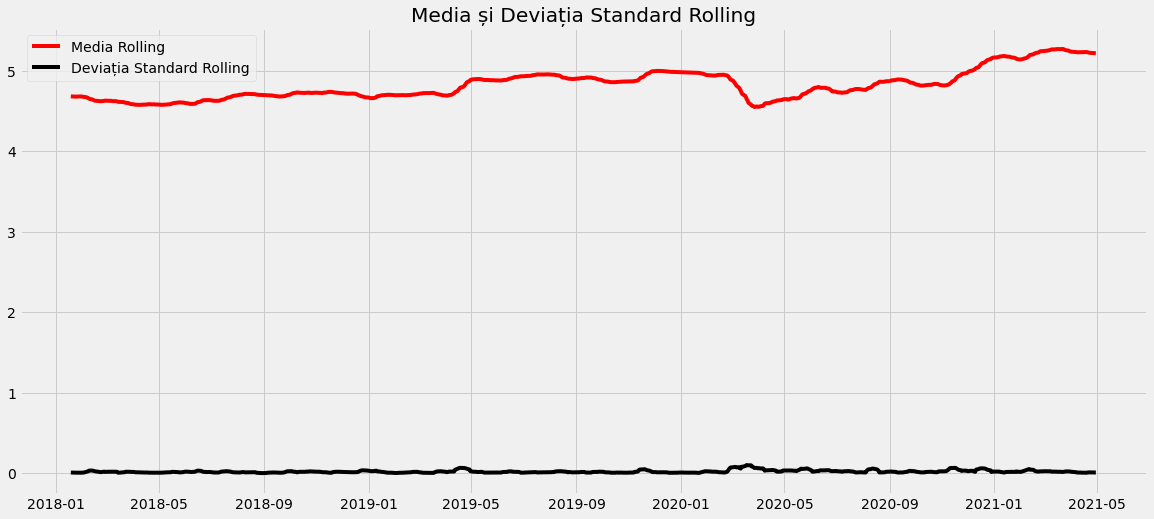

In [8]:
df_log = np.log(df_close)
rolling_mean = df_log.rolling(12).mean()
rolling_std = df_log.rolling(12).std()
plt.title('Media și Deviația Standard Rolling')
plt.plot(rolling_mean, color = 'red', label='Media Rolling')
plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
plt.legend(loc='best')
plt.show()

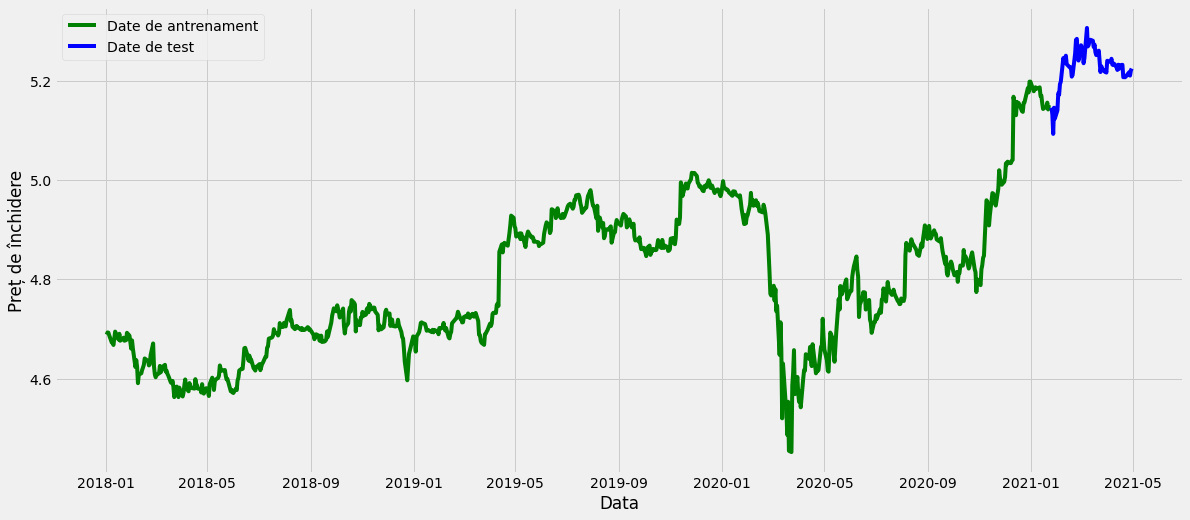

In [9]:
train_data, test_data = df_log[:int(len(df_log)*0.92)], df_log[int(len(df_log)*0.92):]
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(train_data, 'green', label = "Date de antrenament")
plt.plot(test_data, 'blue', label = "Date de test")
plt.legend()

In [10]:
train_data.count()

770

In [26]:
auto_ARIMA = auto_arima(train_data,
                        start_p=0, start_q=0,
                        test = 'adf',
                        max_p=3, max_q=3,
                        m=1,
                        d=2,
                        seasonal=True,
                        start_P=0, 
                        D=0,
                        trace=True,
                        error_action = 'ignore',
                        suppress_warnings=True,
                        stepwise=True,)
print(auto_ARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-3124.786, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-3442.014, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-3558.833, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-3612.746, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-3610.746, Time=0.13 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.830 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  770
Model:               SARIMAX(3, 2, 0)   Log Likelihood                1810.373
Date:                Mon, 14 Jun 2021   AIC                          -3612.746
Time:                        15:23:05   BIC   

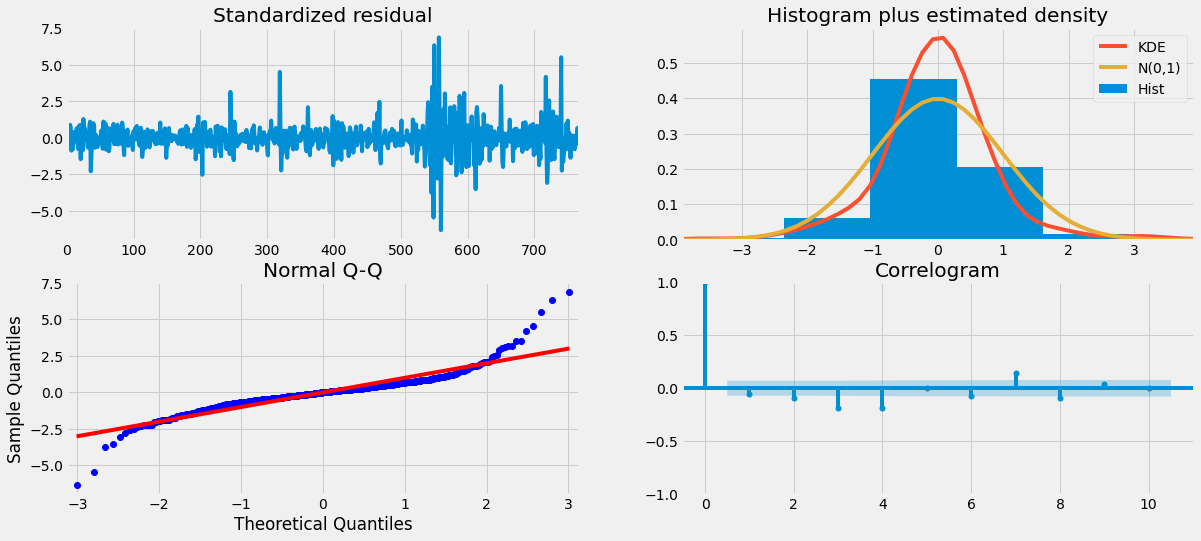

In [12]:
auto_ARIMA.plot_diagnostics()
plt.show()

In [76]:
warnings.filterwarnings('ignore')
model = ARIMA(train_data, order=(3, 2, 0))  
fitted = model.fit(disp=-1,trend=  'nc')  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:           D2.Adj Close   No. Observations:                  768
Model:                 ARIMA(3, 2, 0)   Log Likelihood                1810.374
Method:                       css-mle   S.D. of innovations              0.023
Date:                Sun, 20 Jun 2021   AIC                          -3612.747
Time:                        14:38:29   BIC                          -3594.172
Sample:                             2   HQIC                         -3605.598
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ar.L1.D2.Adj Close    -0.9043      0.035    -26.003      0.000      -0.972      -0.836
ar.L2.D2.Adj Close    -0.5915      0.043    -13.876      0.000      -0.675      -0.508
ar.L3.D2.Adj Close  

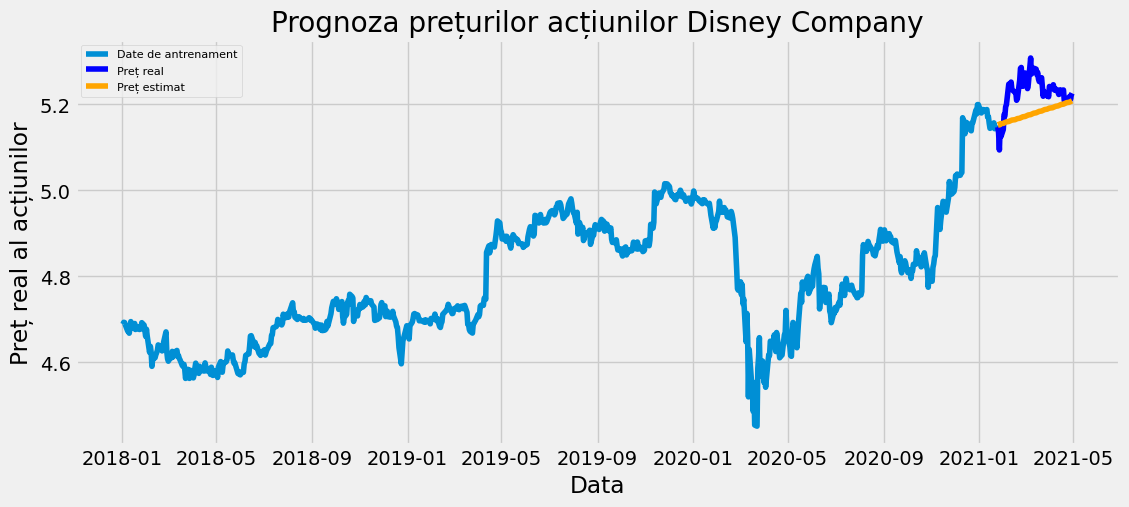

In [77]:
fc, se, conf = fitted.forecast(68, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Date de antrenament')
plt.plot(test_data, color = 'blue', label='Preț real')
plt.plot(fc_series, color = 'orange',label='Preț estimat')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Prognoza prețurilor acțiunilor Disney Company')
plt.xlabel('Data')
plt.ylabel('Preț real al acțiunilor')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [78]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))*100
print('MAPE: '+str(mape))

MSE: 132.61139907923493
MAE: 9.698198932064253
RMSE: 11.51570228337095
MAPE: 5.10277483278575
